In [1]:
import numpy as np
import gym
from gym import spaces
from scipy.stats import norm
import random
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.distributions import Normal
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class BloodSupplyChainEnv(gym.Env):
    def __init__(self, 
                max_capacity       = 5000,
                shelf_life         = 30,
                order_cost         = 0.1,
                transshipment_cost = 0.04,
                shortage_cost      = 100,
                wastage_cost       = 10,
                inventory_cost     = 0.005,
                episode_length     = 365,
                ):
        super(BloodSupplyChainEnv, self).__init__()
        self.num_hospitals        = 2
        self.max_capacity         = max_capacity
        self.shelf_life           = shelf_life
        self.order_cost           = order_cost
        self.transshipment_cost   = transshipment_cost
        self.wastage_cost         = wastage_cost
        self.shortage_cost        = shortage_cost
        self.inventory_cost       = inventory_cost
        self.episode_length       = episode_length
        
        self.observation_space = spaces.Box(low=0, high=self.max_capacity, shape=(60,), dtype=np.int32)
        self.action_space      = spaces.Box(low=0, high=self.max_capacity, shape=(4,) , dtype=np.int32)

        self.state = np.zeros((60,), dtype=np.int32)
        self.day = 0

    def reset(self):
        self.state = np.zeros((60,), dtype=np.int32)
        self.day = 0
        return self.state

    def step(self, action):
        # Make sure the action is within the action space
        action = np.clip(action, 0, self.max_capacity)

        # Unpack the action
        order_h1, order_h2, transship_h1_to_h2, transship_h2_to_h1 = action

        # Process lateral transshipment
        self._transfer_blood(0, 1, transship_h1_to_h2)
        self._transfer_blood(1, 0, transship_h2_to_h1)

        # Process new orders
        self._Process_order(0, order_h1)
        self._Process_order(1, order_h2)

        # Generating Demand
        noise     = random.uniform (0.98, 1.17)
        demand_h1 = int(norm.rvs(noise*18.03, 1.73))
        demand_h2 = int(norm.rvs(noise*20.16, 2.67))

        # Fulfill demand and calculate wastage
        wastage_h1, unfulfilled_h1 = self._fulfill_demand(0, demand_h1)
        wastage_h2, unfulfilled_h2 = self._fulfill_demand(1, demand_h2)

        # Age blood by one day
        self._age_blood()
        self.day += 1

        # Calculate costs
        inventory_cost     = np.sum(self.state) * self.inventory_cost
        wastage_cost       = (wastage_h1         + wastage_h2)         *self.wastage_cost
        shortage_cost      = (unfulfilled_h1     + unfulfilled_h2)     *self.shortage_cost
        transshipment_cost = (transship_h1_to_h2 + transship_h2_to_h1) *self.transshipment_cost
        order_cost         = (order_h1 + order_h2)                     *self.order_cost
        
        # Calculate shared and exclusive rewards
        shared_cost            = wastage_cost + shortage_cost
        order_agent_reward     = -(shared_cost + order_cost + inventory_cost)
        transship_agent_reward = -(shared_cost + transshipment_cost)
        total_reward           = wastage_cost + shortage_cost + order_cost + inventory_cost + transshipment_cost 
    
        info = {
            'total_cost'                 : total_reward,
            'order_agent_reward'         : order_agent_reward,
            'transshipment_agent_reward' : transship_agent_reward,
            'shortage_h1'                : unfulfilled_h1,
            'shortage_h2'                : unfulfilled_h2,
            'wastage_h1'                 : wastage_h1,
            'wastage_h2'                 : wastage_h2,
            'demand_h1'                  : demand_h1,
            'demand_h2'                  : demand_h2,
            "order_h1"                   : order_h1,
            "order_h2"                   : order_h2,
            'transferred_h1_to_h2'       : transship_h1_to_h2,
            'transferred_h2_to_h1'       : transship_h2_to_h1,
        }
        
        done = self.day >= self.episode_length

        return self.state, (order_agent_reward , transship_agent_reward), done, info

    def _Process_order(self, hospital, order_amount):

        start_idx          = hospital * self.shelf_life
        end_idx            = (hospital + 1) * self.shelf_life
        current_stock      = np.sum(self.state[start_idx:end_idx])
        available_capacity = self.max_capacity - current_stock
        accepted_amount    = min(order_amount, available_capacity)

        self.state[start_idx] += accepted_amount

    def _transfer_blood(self, from_hospital, to_hospital, amount):
        from_start           = from_hospital       * self.shelf_life
        from_end             = (from_hospital + 1) * self.shelf_life
        to_start             = to_hospital         * self.shelf_life
        to_end               = (to_hospital + 1)   * self.shelf_life

        available            = np.sum(self.state[from_start:from_end])
        to_hospital_current  = np.sum(self.state[to_start:to_end])
        to_hospital_capacity = self.max_capacity - to_hospital_current

        transferrable        = min(amount, available, to_hospital_capacity)

        transferred = 0
        for i in range(from_end - 1, from_start - 1, -1):
            if self.state[i] > 0:
                to_transfer    = min(self.state[i], transferrable - transferred)
                self.state[i] -= to_transfer

                # Find the corresponding age in the receiving hospital
                age_difference = from_end - i - 1
                to_idx         = to_end - 1 - age_difference
                
                if to_idx >= to_start:
                    self.state[to_idx] += to_transfer
                else:
                    # If the blood would expire after transfer, don't transfer it
                    self.state[i] += to_transfer
                    break

                transferred += to_transfer
                if transferred >= transferrable:
                    break

    def _fulfill_demand(self, hospital, demand):
        start_idx = hospital * self.shelf_life
        end_idx   = (hospital + 1) * self.shelf_life

        wastage     = 0
        unfulfilled = demand

        for i in range(end_idx - 1, start_idx - 1, -1):
            if self.state[i] > 0:
                if i == end_idx - 1:
                    # Blood at the last day of shelf life becomes waste
                    wastage += self.state[i]
                    self.state[i] = 0
                else:
                    # Use the oldest non-expired blood to fulfill demand
                    used = min(self.state[i], unfulfilled)
                    self.state[i] -= used
                    unfulfilled -= used
                    if unfulfilled == 0:
                        break
        return wastage, unfulfilled

    def _age_blood(self):
        
        for h in range(self.num_hospitals):
            start_idx   = h * self.shelf_life
            end_idx     = (h + 1) * self.shelf_life

            self.state[start_idx + 1:end_idx] = self.state[start_idx:end_idx - 1]
            self.state[start_idx] = 0

In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        mean = self.network(state)
        std  = self.log_std.exp().expand_as(mean)
        return Normal(mean, std)

class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        return self.network(state)

In [4]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, 
    lr=3e-4, 
    gamma=0.99, 
    epsilon=0.2, 
    epochs=10, 
    entropy_coef=0.01):

        self.actor            = Actor(state_dim, action_dim).to(device)
        self.critic           = Critic(state_dim).to(device)
        self.actor_optimizer  = Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=lr)
        self.gamma            = gamma
        self.epsilon          = epsilon
        self.epochs           = epochs
        self.entropy_coef     = entropy_coef

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            dist     = self.actor(state)
            action   = dist.sample()
            log_prob = dist.log_prob(action).sum(-1)
        return action.squeeze(0).cpu().numpy(), log_prob.squeeze(0).cpu().numpy()

    def update(self, states, actions, log_probs, rewards, next_states, dones):
        states        = torch.FloatTensor(np.array(states)).to(device)
        actions       = torch.FloatTensor(np.array(actions)).to(device)
        old_log_probs = torch.FloatTensor(np.array(log_probs)).to(device)
        rewards       = torch.FloatTensor(np.array(rewards)).to(device)
        next_states   = torch.FloatTensor(np.array(next_states)).to(device)
        dones         = torch.FloatTensor(np.array(dones)).to(device)

        # Compute advantages
        with torch.no_grad():
            values      = self.critic(states).squeeze()
            next_values = self.critic(next_states).squeeze()
            advantages  = rewards + self.gamma * next_values * (1 - dones) - values
            returns     = advantages + values
            advantages  = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(self.epochs):
            # Actor loss
            dist          = self.actor(states)
            new_log_probs = dist.log_prob(actions).sum(-1)
            ratio         = torch.exp(new_log_probs - old_log_probs)
            surr1         = ratio * advantages
            surr2         = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages
            actor_loss    = -torch.min(surr1, surr2).mean()

            # Entropy bonus
            entropy     = dist.entropy().mean()
            actor_loss -= self.entropy_coef * entropy

            # Critic loss
            value_pred  = self.critic(states).squeeze()
            critic_loss = F.mse_loss(value_pred, returns)

            # Update actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=0.5)
            self.actor_optimizer.step()

            # Update critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=0.5)
            self.critic_optimizer.step()

In [159]:
def Train_Multi_Agent_PPO(env, order_agent, transship_agent, num_episodes=1000, max_steps=120):
    logs = defaultdict(list)
    best_reward = float('-inf')
    best_order_agent = None
    best_transship_agent = None

    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        episode_reward = 0
        order_states, order_actions, order_log_probs, order_rewards, order_next_states, order_dones = [], [], [], [], [], []
        transship_states, transship_actions, transship_log_probs, transship_rewards, transship_next_states, transship_dones = [], [], [], [], [], []

        for step in range(max_steps):
            order_action, order_log_prob = order_agent.get_action(state)
            transship_action, transship_log_prob = transship_agent.get_action(state)

            action = np.concatenate([order_action, transship_action])
            
            next_state, reward, done, _ = env.step(action)
            order_reward, transship_reward = reward

            episode_reward += order_reward + transship_reward

            # Store data for both agents
            order_states.append(state)
            order_actions.append(order_action)
            order_log_probs.append(order_log_prob)
            order_rewards.append(order_reward)
            order_next_states.append(next_state)
            order_dones.append(done)

            transship_states.append(state)
            transship_actions.append(transship_action)
            transship_log_probs.append(transship_log_prob)
            transship_rewards.append(transship_reward)
            transship_next_states.append(next_state)
            transship_dones.append(done)

            state = next_state

            if done:
                break

        # Update both agents
        order_agent.update(order_states, order_actions, order_log_probs, order_rewards, order_next_states, order_dones)
        transship_agent.update(transship_states, transship_actions, transship_log_probs, transship_rewards, transship_next_states, transship_dones)

        logs["episode_reward"].append(episode_reward)
        logs["episode_length"].append(step + 1)

        if episode % 100 == 0:
            avg_reward = np.mean(logs["episode_reward"][-100:])
            avg_length = np.mean(logs["episode_length"][-100:])
            print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Avg Length: {avg_length:.2f}")

    return logs, order_agent, transship_agent

# Training

In [160]:
# The rest of your code remains the same
env = BloodSupplyChainEnv(
    max_capacity       = 5000,
    shelf_life         = 30,
    order_cost         = 0.1,
    transshipment_cost = 0.04,
    shortage_cost      = 100,
    wastage_cost       = 1,
    inventory_cost     = 0.005,
    episode_length     = 365,
)

state_dim = env.observation_space.shape[0]
order_action_dim = 2
transship_action_dim = 2

order_agent     = PPOAgent(state_dim, order_action_dim,
                           lr=3e-4, gamma=0.99, epsilon=0.2, epochs=10, entropy_coef=0.01)
transship_agent = PPOAgent(state_dim, transship_action_dim,
                           lr=3e-4, gamma=0.99, epsilon=0.2, epochs=10, entropy_coef=0.01)  

In [186]:
logs, best_order_agent, best_transship_agent = Train_Multi_Agent_PPO(env, order_agent, transship_agent, num_episodes=20000, max_steps=256)

Episode 0, Avg Reward: -202676.58, Avg Length: 256.00
Episode 1000, Avg Reward: -142033.13, Avg Length: 256.00
Episode 2000, Avg Reward: -104886.15, Avg Length: 256.00
Episode 3000, Avg Reward: -74637.30, Avg Length: 256.00
Episode 4000, Avg Reward: -58822.95, Avg Length: 256.00
Episode 5000, Avg Reward: -44206.61, Avg Length: 256.00
Episode 6000, Avg Reward: -35057.44, Avg Length: 256.00
Episode 7000, Avg Reward: -28739.76, Avg Length: 256.00
Episode 8000, Avg Reward: -20520.31, Avg Length: 256.00
Episode 9000, Avg Reward: -18163.23, Avg Length: 256.00
Episode 10000, Avg Reward: -16010.50, Avg Length: 256.00
Episode 11000, Avg Reward: -14470.83, Avg Length: 256.00
Episode 12000, Avg Reward: -13937.96, Avg Length: 256.00
Episode 13000, Avg Reward: -13233.98, Avg Length: 256.00
Episode 14000, Avg Reward: -12156.95, Avg Length: 256.00
Episode 15000, Avg Reward: -11634.59, Avg Length: 256.00
Episode 16000, Avg Reward: -11440.45, Avg Length: 256.00
Episode 17000, Avg Reward: -11629.17, Avg

# Plotting the Result

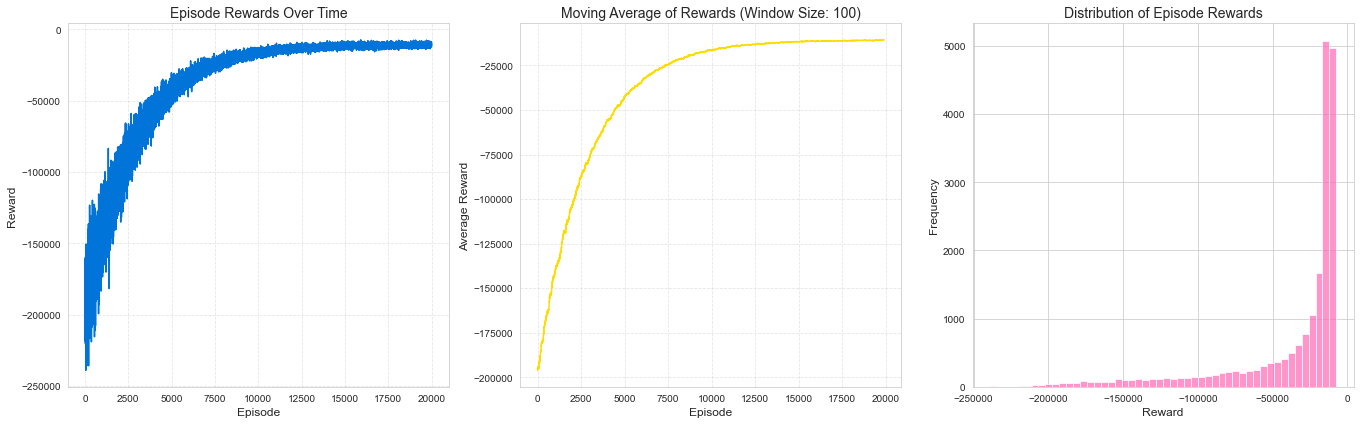

In [188]:
# Plotting
plt.figure(figsize=(19, 6))

# Plot 1: Episode Rewards
plt.subplot(1, 3, 1)
plt.plot(logs["episode_reward"], color='#0074D9')
plt.title("Episode Rewards Over Time", fontsize=14)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Plot 3: Moving Average of Rewards
window_size = 100
moving_avg = np.convolve(logs["episode_reward"], np.ones(window_size)/window_size, mode='valid')
plt.subplot(1, 3, 2)
plt.plot(moving_avg, color='#FFDC00')
plt.title(f"Moving Average of Rewards (Window Size: {window_size})", fontsize=14)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Average Reward", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Plot 4: Histogram of Rewards
plt.subplot(1, 3, 3)
plt.hist(logs["episode_reward"], bins=50, color='#FF69B4', alpha=0.7)
plt.title("Distribution of Episode Rewards", fontsize=14)
plt.xlabel("Reward", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

# Evaluation

In [8]:
# Defining Environment
env = BloodSupplyChainEnv()
state = env.reset()

h1_demand = []
h2_demand = []
h1_inventory_level = []
h2_inventory_level = []
h1_shortage = [] 
h2_shortage = []
h1_wastage = []
h2_wastage = []
h1_order = []
h2_order = []
h1_transshipment = []
h2_transshipment = []

for step in range(365):
    h1_inventory_level.append(np.sum(state[:30]))
    h2_inventory_level.append(np.sum(state[30:]))

    order_action    , _ = order_agent.get_action(state)
    transship_action, _ = transship_agent.get_action(state)

    order_action_h1          , order_action_h2           = order_action
    transship_action_h1_to_h2, transship_action_h2_to_h1 = transship_action

    h1_order.append(order_action_h1)
    h2_order.append(order_action_h2)
    h1_transshipment.append(transship_action_h1_to_h2)
    h2_transshipment.append(transship_action_h2_to_h1)

    action = np.concatenate([order_action,transship_action]).reshape(-1, )

    state, reward, done, info = env.step(action) 
    
    h1_shortage.append(info['shortage_h1'])
    h2_shortage.append(info['shortage_h2'])
    h1_wastage.append(info['wastage_h1'])
    h2_wastage.append(info['wastage_h2'])
    h1_demand.append(info['demand_h1'])
    h2_demand.append(info['demand_h2'])

    print(f"Step {step + 1}")
    print(f"Order Action: {int(order_action_h1)} {int(order_action_h2)}")
    print(f"Transship Action: {int(transship_action_h1_to_h2)} {int(transship_action_h2_to_h1)}")
    print(f"Demand H1: {int(info['demand_h1'])} Demand H2 : {int(info['demand_h2'])}")
    print(f"Environment state: {state} \n")

Step 1
Order Action: 21 21
Transship Action: 0 0
Demand H1: 19 Demand H2 : 20
Environment state: [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

Step 2
Order Action: 25 28
Transship Action: 0 0
Demand H1: 20 Demand H2 : 19
Environment state: [ 0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0] 

Step 3
Order Action: 24 25
Transship Action: 0 0
Demand H1: 15 Demand H2 : 18
Environment state: [ 0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0] 

Step 4
Order Action: 23 27
Transship Action: 0 0
Demand H1: 23 Demand H2 : 19
Environment state: [ 0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25  0  0  0  0  0  0

In [32]:
from tabulate import tabulate

# Creating the table data
table_data = [
    ["Criteria", "Hospital 1", "Hospital 2" , "Total"],
    ["Demand", sum(h1_demand), sum(h2_demand) , sum(h1_demand) + sum(h2_demand)],
    ["Order", int(sum(h1_order)), int(sum(h2_order)), int(sum(h1_order) + sum(h2_order))],
    ["Transhipment", sum(h1_transshipment), sum(h2_transshipment) , sum(h1_transshipment) + sum(h2_transshipment)],
    ["Mean inventory", sum(h1_inventory_level)//len(h1_inventory_level), sum(h2_inventory_level)//len(h2_inventory_level) , (sum(h1_inventory_level)//len(h1_inventory_level) + sum(h2_inventory_level)//len(h2_inventory_level))//2],
    ["Wastage", sum(h1_wastage), sum(h2_wastage) , sum(h1_wastage) + sum(h2_wastage)],
    ["Shortage", sum(h1_shortage), sum(h2_shortage), sum(h1_shortage) + sum(h2_shortage)],
]

# Printing the table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

╒════════════════╤══════════════╤══════════════╤═════════╕
│ Criteria       │   Hospital 1 │   Hospital 2 │   Total │
╞════════════════╪══════════════╪══════════════╪═════════╡
│ Demand         │         6868 │         7646 │   14514 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Order          │         7373 │         8618 │   15992 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Transhipment   │          242 │          489 │     731 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Mean inventory │          432 │          465 │     448 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Wastage        │           56 │            9 │      65 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Shortage       │            0 │            0 │       0 │
╘════════════════╧══════════════╧══════════════╧═════════╛


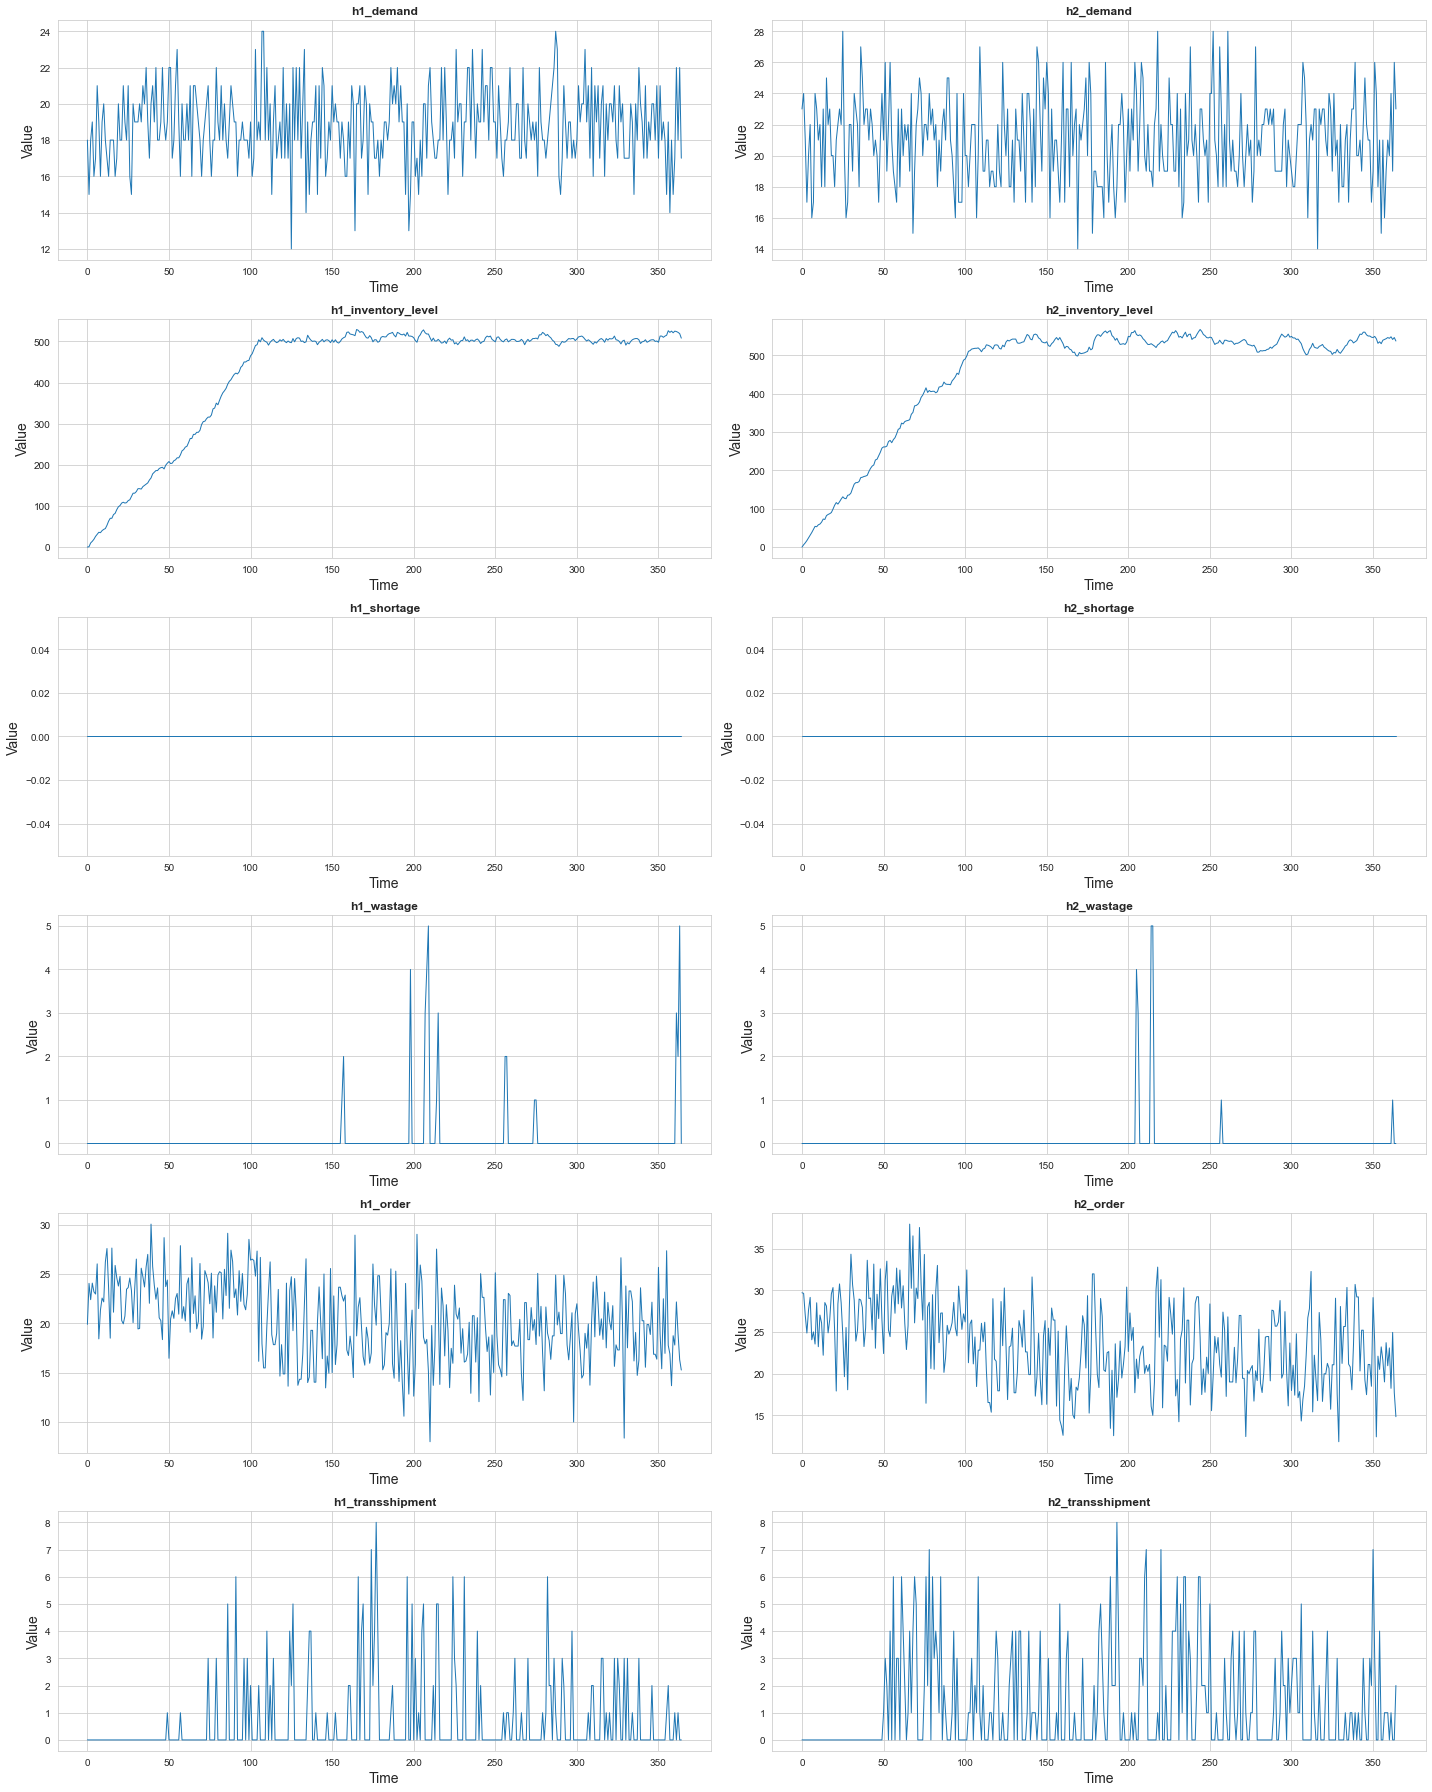

In [81]:
# Set the style of the plots
sns.set_style("whitegrid")

# Create a figure with 12 subplots (6 rows and 2 columns)
fig, axs = plt.subplots(6, 2, figsize=(20, 25))

# Define the data and titles
data = [h1_demand, h2_demand, h1_inventory_level, h2_inventory_level, h1_shortage, h2_shortage, h1_wastage, h2_wastage, h1_order, h2_order, h1_transshipment, h2_transshipment]
titles = ['h1_demand', 'h2_demand', 'h1_inventory_level', 'h2_inventory_level', 'h1_shortage', 'h2_shortage', 'h1_wastage', 'h2_wastage', 'h1_order', 'h2_order', 'h1_transshipment', 'h2_transshipment']

# Plot data
for i, ax in enumerate(axs.flatten()):
    ax.plot(data[i], linewidth=1)
    ax.set_title(titles[i], fontweight='bold')
    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)

# Add some space between subplots to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()

# Impact of using Lateral Transshipment

In [36]:
# Defining Environment
env = BloodSupplyChainEnv()
state = env.reset()

h1_demand = []
h2_demand = []
h1_inventory_level_2 = []
h2_inventory_level_2 = []
h1_shortage = [] 
h2_shortage = []
h1_wastage = []
h2_wastage = []
h1_order = []
h2_order = []
h1_transshipment = []
h2_transshipment = []

for step in range(365):
    h1_inventory_level_2.append(np.sum(state[:30]))
    h2_inventory_level_2.append(np.sum(state[30:]))

    order_action    , _ = order_agent.get_action(state)
    transship_action, _ = transship_agent.get_action(state)

    order_action_h1 , order_action_h2 = order_action
    
    # Setting the Transshipment action to zero
    transship_action_h1_to_h2, transship_action_h2_to_h1 = 0 , 0
    zero_transship = np.array[0,0]

    h1_order.append(order_action_h1)
    h2_order.append(order_action_h2)
    h1_transshipment.append(transship_action_h1_to_h2)
    h2_transshipment.append(transship_action_h2_to_h1)

    action = np.concatenate([order_action,zero_transship]).reshape(-1, )

    state, reward, done, info = env.step(action) 
    
    h1_shortage.append(info['shortage_h1'])
    h2_shortage.append(info['shortage_h2'])
    h1_wastage.append(info['wastage_h1'])
    h2_wastage.append(info['wastage_h2'])
    h1_demand.append(info['demand_h1'])
    h2_demand.append(info['demand_h2'])

    print(f"Step {step + 1}")
    print(f"Order Action: {int(order_action_h1)} {int(order_action_h2)}")
    print(f"Transship Action: {int(transship_action_h1_to_h2)} {int(transship_action_h2_to_h1)}")
    print(f"Demand H1: {int(info['demand_h1'])} Demand H2 : {int(info['demand_h2'])}")
    print(f"Environment state: {state} \n")

Step 1
Order Action: 24 26
Transship Action: 0 0
Demand H1: 18 Demand H2 : 18
Environment state: [0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

Step 2
Order Action: 21 26
Transship Action: 0 0
Demand H1: 22 Demand H2 : 25
Environment state: [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 9 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

Step 3
Order Action: 18 23
Transship Action: 0 0
Demand H1: 20 Demand H2 : 25
Environment state: [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

Step 4
Order Action: 25 28
Transship Action: 0 0
Demand H1: 17 Demand H2 : 20
Environment state: [ 0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0] 

Step 5
Order Action: 21 22
Transship Action: 0 0
De

In [39]:
from tabulate import tabulate

# Creating the table data
table_data = [
    ["Criteria", "Hospital 1", "Hospital 2" , "Total"],
    ["Demand", sum(h1_demand), sum(h2_demand) , sum(h1_demand) + sum(h2_demand)],
    ["Order", int(sum(h1_order)), int(sum(h2_order)), int(sum(h1_order) + sum(h2_order))],
    ["Transhipment", 0 , 0 , 0],
    ["Mean inventory", sum(h1_inventory_level)//len(h1_inventory_level), sum(h2_inventory_level)//len(h2_inventory_level) , (sum(h1_inventory_level)//len(h1_inventory_level) + sum(h2_inventory_level)//len(h2_inventory_level))//2],
    ["Wastage", sum(h1_wastage), sum(h2_wastage) , sum(h1_wastage) + sum(h2_wastage)],
    ["Shortage", sum(h1_shortage), sum(h2_shortage), sum(h1_shortage) + sum(h2_shortage)],
]

# Printing the table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

╒════════════════╤══════════════╤══════════════╤═════════╕
│ Criteria       │   Hospital 1 │   Hospital 2 │   Total │
╞════════════════╪══════════════╪══════════════╪═════════╡
│ Demand         │         6928 │         7722 │   14650 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Order          │         7613 │         8761 │   16375 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Transhipment   │            0 │            0 │       0 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Mean inventory │          399 │          518 │     458 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Wastage        │            0 │          276 │     276 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Shortage       │            0 │            0 │       0 │
╘════════════════╧══════════════╧══════════════╧═════════╛


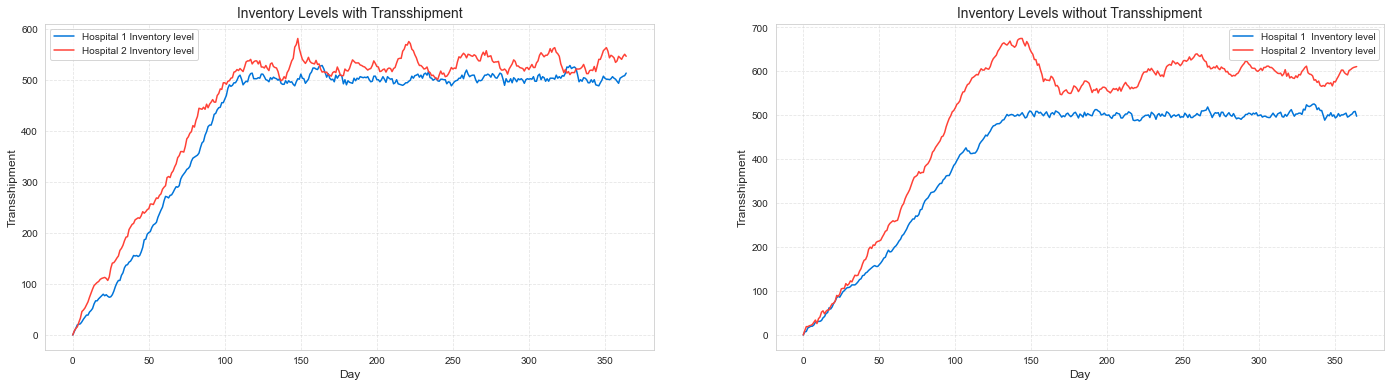

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(24, 6))

# Plot inventory levels with transshipment
axs[0].plot(h1_inventory_level, label="Hospital 1 Inventory level", color='#0074D9')
axs[0].plot(h2_inventory_level, label="Hospital 2 Inventory level", color='#FF4136')
axs[0].set_title("Inventory Levels with Transshipment", fontsize=14)
axs[0].set_xlabel("Day", fontsize=12)
axs[0].set_ylabel("Transshipment", fontsize=12)
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.5)

# Plot inventory levels without transshipment
axs[1].plot(h1_inventory_level_2, label="Hospital 1  Inventory level", color='#0074D9')
axs[1].plot(h2_inventory_level_2, label="Hospital 2  Inventory level", color='#FF4136')
axs[1].set_title("Inventory Levels without Transshipment", fontsize=14)
axs[1].set_xlabel("Day", fontsize=12)
axs[1].set_ylabel("Transshipment", fontsize=12)
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

# Model Resilience in Disruption Scenario

In [23]:
class BloodSupplyChainEnvDisruption(gym.Env):
    def __init__(self, 
                max_capacity       = 5000,
                shelf_life         = 30,
                order_cost         = 0.1,
                transshipment_cost = 0.04,
                shortage_cost      = 100,
                wastage_cost       = 10,
                inventory_cost     = 0.005,
                episode_length     = 365,
                ):
        super(BloodSupplyChainEnvDisruption, self).__init__()
        self.num_hospitals        = 2
        self.max_capacity         = max_capacity
        self.shelf_life           = shelf_life
        self.order_cost           = order_cost
        self.transshipment_cost   = transshipment_cost
        self.wastage_cost         = wastage_cost
        self.shortage_cost        = shortage_cost
        self.inventory_cost       = inventory_cost
        self.episode_length       = episode_length
        
        self.observation_space = spaces.Box(low=0, high=self.max_capacity, shape=(60,), dtype=np.int32)
        self.action_space      = spaces.Box(low=0, high=self.max_capacity, shape=(4,) , dtype=np.int32)

        self.state = np.zeros((60,), dtype=np.int32)
        self.day = 0

    def reset(self):
        self.state = np.zeros((60,), dtype=np.int32)
        self.day = 0
        return self.state

    def step(self, action):
        # Make sure the action is within the action space
        action = np.clip(action, 0, self.max_capacity)

        # Unpack the action
        order_h1, order_h2, transship_h1_to_h2, transship_h2_to_h1 = action

        # Process lateral transshipment
        self._transfer_blood(0, 1, transship_h1_to_h2)
        self._transfer_blood(1, 0, transship_h2_to_h1)

        # Process new orders
        self._Process_order(0, order_h1)
        self._Process_order(1, order_h2)

        # Generating Demand
        noise     = random.uniform (0.98, 1.17)
        demand_h1 = int(norm.rvs(noise*18.03, 1.73))
        demand_h2 = int(norm.rvs(noise*20.16, 2.67))
        
        # Doubleing Demand betwwen day 200 to 220
        if self.day >= 200 and self.day <= 225:
            demand_h1 *= 2
            demand_h2 *= 2

        # Fulfill demand and calculate wastage
        wastage_h1, unfulfilled_h1 = self._fulfill_demand(0, demand_h1)
        wastage_h2, unfulfilled_h2 = self._fulfill_demand(1, demand_h2)

        # Age blood by one day
        self._age_blood()
        self.day += 1

        # Calculate costs
        inventory_cost     = np.sum(self.state) * self.inventory_cost
        wastage_cost       = (wastage_h1         + wastage_h2)         *self.wastage_cost
        shortage_cost      = (unfulfilled_h1     + unfulfilled_h2)     *self.shortage_cost
        transshipment_cost = (transship_h1_to_h2 + transship_h2_to_h1) *self.transshipment_cost
        order_cost         = (order_h1 + order_h2)                     *self.order_cost
        
        # Calculate shared and exclusive rewards
        shared_cost            = wastage_cost + shortage_cost
        order_agent_reward     = -(shared_cost + order_cost + inventory_cost)
        transship_agent_reward = -(shared_cost + transshipment_cost)
        total_reward           = wastage_cost + shortage_cost + order_cost + inventory_cost + transshipment_cost 
    
        info = {
            'total_cost'                 : total_reward,
            'order_agent_reward'         : order_agent_reward,
            'transshipment_agent_reward' : transship_agent_reward,
            'shortage_h1'                : unfulfilled_h1,
            'shortage_h2'                : unfulfilled_h2,
            'wastage_h1'                 : wastage_h1,
            'wastage_h2'                 : wastage_h2,
            'demand_h1'                  : demand_h1,
            'demand_h2'                  : demand_h2,
            "order_h1"                   : order_h1,
            "order_h2"                   : order_h2,
            'transferred_h1_to_h2'       : transship_h1_to_h2,
            'transferred_h2_to_h1'       : transship_h2_to_h1,
        }
        
        done = self.day >= self.episode_length

        return self.state, (order_agent_reward , transship_agent_reward), done, info

    def _Process_order(self, hospital, order_amount):

        start_idx          = hospital * self.shelf_life
        end_idx            = (hospital + 1) * self.shelf_life
        current_stock      = np.sum(self.state[start_idx:end_idx])
        available_capacity = self.max_capacity - current_stock
        accepted_amount    = min(order_amount, available_capacity)

        self.state[start_idx] += accepted_amount

    def _transfer_blood(self, from_hospital, to_hospital, amount):
        from_start           = from_hospital       * self.shelf_life
        from_end             = (from_hospital + 1) * self.shelf_life
        to_start             = to_hospital         * self.shelf_life
        to_end               = (to_hospital + 1)   * self.shelf_life

        available            = np.sum(self.state[from_start:from_end])
        to_hospital_current  = np.sum(self.state[to_start:to_end])
        to_hospital_capacity = self.max_capacity - to_hospital_current

        transferrable        = min(amount, available, to_hospital_capacity)

        transferred = 0
        for i in range(from_end - 1, from_start - 1, -1):
            if self.state[i] > 0:
                to_transfer    = min(self.state[i], transferrable - transferred)
                self.state[i] -= to_transfer

                # Find the corresponding age in the receiving hospital
                age_difference = from_end - i - 1
                to_idx         = to_end - 1 - age_difference
                
                if to_idx >= to_start:
                    self.state[to_idx] += to_transfer
                else:
                    # If the blood would expire after transfer, don't transfer it
                    self.state[i] += to_transfer
                    break

                transferred += to_transfer
                if transferred >= transferrable:
                    break

    def _fulfill_demand(self, hospital, demand):
        start_idx = hospital * self.shelf_life
        end_idx   = (hospital + 1) * self.shelf_life

        wastage     = 0
        unfulfilled = demand

        for i in range(end_idx - 1, start_idx - 1, -1):
            if self.state[i] > 0:
                if i == end_idx - 1:
                    # Blood at the last day of shelf life becomes waste
                    wastage += self.state[i]
                    self.state[i] = 0
                else:
                    # Use the oldest non-expired blood to fulfill demand
                    used = min(self.state[i], unfulfilled)
                    self.state[i] -= used
                    unfulfilled -= used
                    if unfulfilled == 0:
                        break
        return wastage, unfulfilled

    def _age_blood(self):
        
        for h in range(self.num_hospitals):
            start_idx   = h * self.shelf_life
            end_idx     = (h + 1) * self.shelf_life

            self.state[start_idx + 1:end_idx] = self.state[start_idx:end_idx - 1]
            self.state[start_idx] = 0

In [63]:
# Defining Environment
env = BloodSupplyChainEnvDisruption()
state = env.reset()

h1_demand = []
h2_demand = []
h1_inventory_level_3 = []
h2_inventory_level_3 = []
h1_shortage = [] 
h2_shortage = []
h1_wastage = []
h2_wastage = []
h1_order = []
h2_order = []
h1_transshipment = []
h2_transshipment = []

for step in range(365):
    h1_inventory_level_3.append(np.sum(state[:30]))
    h2_inventory_level_3.append(np.sum(state[30:]))

    order_action    , _ = order_agent.get_action(state)
    transship_action, _ = transship_agent.get_action(state)

    order_action_h1 , order_action_h2 = order_action
    transship_action_h1_to_h2, transship_action_h2_to_h1 = transship_action

    h1_order.append(order_action_h1)
    h2_order.append(order_action_h2)
    h1_transshipment.append(transship_action_h1_to_h2)
    h2_transshipment.append(transship_action_h2_to_h1)

    action = np.concatenate([order_action,transship_action]).reshape(-1, )

    state, reward, done, info = env.step(action) 
    
    h1_shortage.append(info['shortage_h1'])
    h2_shortage.append(info['shortage_h2'])
    h1_wastage.append(info['wastage_h1'])
    h2_wastage.append(info['wastage_h2'])
    h1_demand.append(info['demand_h1'])
    h2_demand.append(info['demand_h2'])

    print(f"Step {step + 1}")
    print(f"Order Action: {int(order_action_h1)} {int(order_action_h2)}")
    print(f"Transship Action: {int(transship_action_h1_to_h2)} {int(transship_action_h2_to_h1)}")
    print(f"Demand H1: {int(info['demand_h1'])} Demand H2 : {int(info['demand_h2'])}")
    print(f"Environment state: {state} \n")

Step 1
Order Action: 22 26
Transship Action: 0 0
Demand H1: 20 Demand H2 : 18
Environment state: [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

Step 2
Order Action: 24 30
Transship Action: 0 0
Demand H1: 20 Demand H2 : 21
Environment state: [ 0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0] 

Step 3
Order Action: 22 34
Transship Action: 0 0
Demand H1: 17 Demand H2 : 20
Environment state: [ 0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0] 

Step 4
Order Action: 22 27
Transship Action: 0 0
Demand H1: 17 Demand H2 : 24
Environment state: [ 0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 27  7  0  0  0  0  0

In [66]:
from tabulate import tabulate

# Creating the table data
table_data = [
    ["Criteria", "Hospital 1", "Hospital 2" , "Total"],
    ["Demand", sum(h1_demand), sum(h2_demand) , sum(h1_demand) + sum(h2_demand)],
    ["Order", int(sum(h1_order)), int(sum(h2_order)), int(sum(h1_order) + sum(h2_order))],
    ["Transhipment", sum(h1_transshipment) , sum(h2_transshipment) , sum(h1_transshipment) + sum(h2_transshipment)],
    ["Mean inventory", sum(h1_inventory_level_3)//len(h1_inventory_level_3), sum(h2_inventory_level_3)//len(h2_inventory_level_3) , (sum(h1_inventory_level_3)//len(h1_inventory_level_3) + sum(h2_inventory_level_3)//len(h2_inventory_level_3))//2],
    ["Wastage", sum(h1_wastage), sum(h2_wastage) , sum(h1_wastage) + sum(h2_wastage)],
    ["Shortage", sum(h1_shortage), sum(h2_shortage), sum(h1_shortage) + sum(h2_shortage)],
]

# Printing the table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

╒════════════════╤══════════════╤══════════════╤═════════╕
│ Criteria       │   Hospital 1 │   Hospital 2 │   Total │
╞════════════════╪══════════════╪══════════════╪═════════╡
│ Demand         │         7318 │         8261 │   15579 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Order          │         7860 │         9123 │   16983 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Transhipment   │          239 │          377 │     616 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Mean inventory │          355 │          389 │     372 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Wastage        │            5 │            0 │       5 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Shortage       │            0 │            0 │       0 │
╘════════════════╧══════════════╧══════════════╧═════════╛


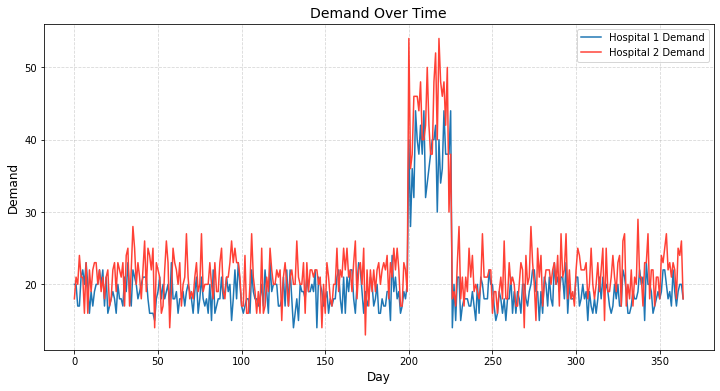

In [70]:
# Plot Transshipment h1 and h2 in the same plot
plt.figure(figsize=(12, 6))
plt.plot(h1_demand, label="Hospital 1 Demand")   
plt.plot(h2_demand, label="Hospital 2 Demand", color='#FF4136')
plt.title("Demand Over Time", fontsize=14)
plt.xlabel("Day", fontsize=12)
plt.ylabel("Demand", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


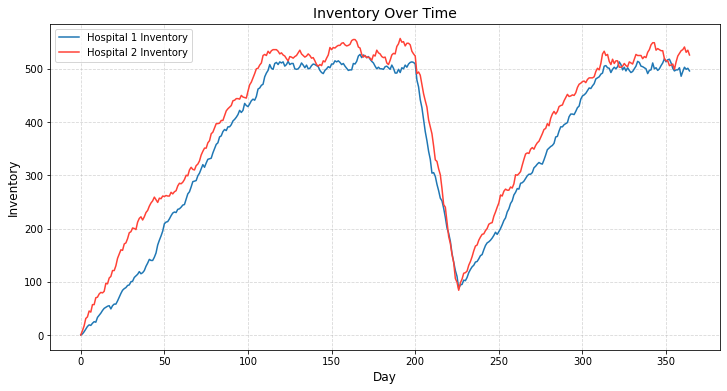

In [67]:
# Plot Transshipment h1 and h2 in the same plot
plt.figure(figsize=(12, 6))
plt.plot(h1_inventory_level_3, label="Hospital 1 Inventory")   
plt.plot(h2_inventory_level_3, label="Hospital 2 Inventory", color='#FF4136')
plt.title("Inventory Over Time", fontsize=14)
plt.xlabel("Day", fontsize=12)
plt.ylabel("Inventory", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# Sensitivity Analysis on Environment Parameters

**In Normal Situation**

In [47]:
# Defining Environment
env = BloodSupplyChainEnv( max_capacity       = 400,
                           shelf_life         = 30,
                           order_cost         = 0.1,
                           transshipment_cost = 0.04,
                           shortage_cost      = 100,
                           wastage_cost       = 1,
                           inventory_cost     = 0.005,
                           episode_length     = 365,
                         )
state = env.reset()

h1_demand = []
h2_demand = []
h1_inventory_level_2 = []
h2_inventory_level_2 = []
h1_shortage = [] 
h2_shortage = []
h1_wastage = []
h2_wastage = []
h1_order = []
h2_order = []
h1_transshipment = []
h2_transshipment = []

for step in range(365):
    h1_inventory_level_2.append(np.sum(state[:30]))
    h2_inventory_level_2.append(np.sum(state[30:]))

    order_action    , _ = order_agent.get_action(state)
    transship_action, _ = transship_agent.get_action(state)
   
    order_action_h1 , order_action_h2 = order_action

    # Clip the order action to 0 and available capacity
    order_action_h1 = np.clip(order_action_h1, 0, env.max_capacity - np.sum(state[:30]))
    order_action_h2 = np.clip(order_action_h2, 0, env.max_capacity - np.sum(state[30:]))

    # Clip
    transship_action_h1_to_h2, transship_action_h2_to_h1 = transship_action



    h1_order.append(order_action_h1)
    h2_order.append(order_action_h2)
    h1_transshipment.append(transship_action_h1_to_h2)
    h2_transshipment.append(transship_action_h2_to_h1)

    action = np.concatenate([order_action,transship_action]).reshape(-1, )

    state, reward, done, info = env.step(action) 
    
    h1_shortage.append(info['shortage_h1'])
    h2_shortage.append(info['shortage_h2'])
    h1_wastage.append(info['wastage_h1'])
    h2_wastage.append(info['wastage_h2'])
    h1_demand.append(info['demand_h1'])
    h2_demand.append(info['demand_h2'])

    print(f"Step {step + 1}")
    print(f"Order Action: {int(order_action_h1)} {int(order_action_h2)}")
    print(f"Transship Action: {int(transship_action_h1_to_h2)} {int(transship_action_h2_to_h1)}")
    print(f"Demand H1: {int(info['demand_h1'])} Demand H2 : {int(info['demand_h2'])}")
    print(f"Environment state: {state} \n")

Step 1
Order Action: 26 30
Transship Action: 0 0
Demand H1: 19 Demand H2 : 24
Environment state: [0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

Step 2
Order Action: 27 25
Transship Action: 0 0
Demand H1: 21 Demand H2 : 25
Environment state: [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0] 

Step 3
Order Action: 20 24
Transship Action: 0 0
Demand H1: 21 Demand H2 : 21
Environment state: [ 0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0] 

Step 4
Order Action: 18 25
Transship Action: 0 0
Demand H1: 18 Demand H2 : 19
Environment state: [ 0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 15  0  0  0  0  0  0

In [48]:
from tabulate import tabulate

# Creating the table data
table_data = [
    ["Criteria", "Hospital 1", "Hospital 2" , "Total"],
    ["Demand", sum(h1_demand), sum(h2_demand) , sum(h1_demand) + sum(h2_demand)],
    ["Order", int(sum(h1_order)), int(sum(h2_order)), int(sum(h1_order) + sum(h2_order))],
    ["Transhipment", sum(h1_transshipment) , sum(h2_transshipment) , sum(h1_transshipment) + sum(h2_transshipment)],
    ["Mean inventory", sum(h1_inventory_level)//len(h1_inventory_level), sum(h2_inventory_level)//len(h2_inventory_level) , (sum(h1_inventory_level)//len(h1_inventory_level) + sum(h2_inventory_level)//len(h2_inventory_level))//2],
    ["Wastage", sum(h1_wastage), sum(h2_wastage) , sum(h1_wastage) + sum(h2_wastage)],
    ["Shortage", sum(h1_shortage), sum(h2_shortage), sum(h1_shortage) + sum(h2_shortage)],
]

# Printing the table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

╒════════════════╤══════════════╤══════════════╤═════════╕
│ Criteria       │   Hospital 1 │   Hospital 2 │   Total │
╞════════════════╪══════════════╪══════════════╪═════════╡
│ Demand         │         6860 │         7722 │   14582 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Order          │         7598 │         8252 │   15850 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Transhipment   │          397 │          172 │     569 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Mean inventory │          325 │          336 │     330 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Wastage        │            0 │            0 │       0 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Shortage       │            0 │            0 │       0 │
╘════════════════╧══════════════╧══════════════╧═════════╛


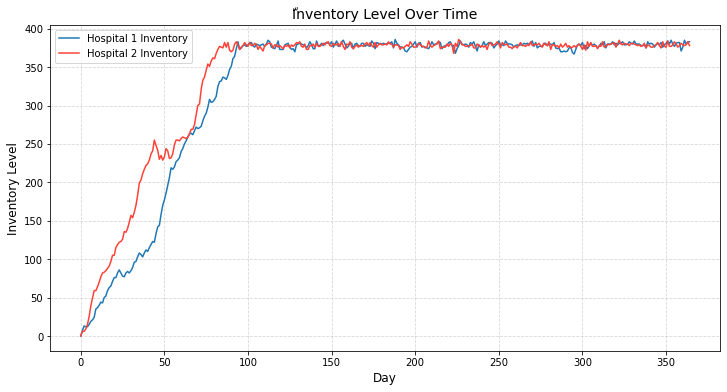

In [51]:
# Plot Transshipment h1 and h2 in the same plot
plt.figure(figsize=(12, 6))
plt.plot(h1_inventory_level, label="Hospital 1 Inventory")   
plt.plot(h2_inventory_level, label="Hospital 2 Inventory", color='#FF4136')
plt.title("ّInventory Level Over Time", fontsize=14)
plt.xlabel("Day", fontsize=12)
plt.ylabel("Inventory Level", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

**In Disruption Situation**

In [ ]:
# Defining Environment
env = BloodSupplyChainEnv( max_capacity = 400,
                           shelf_life         = 30,
                           order_cost         = 0.1,
                           transshipment_cost = 0.04,
                           shortage_cost      = 100,
                           wastage_cost       = 1,
                           inventory_cost     = 0.005,
                           episode_length     = 365,
                         )
state = env.reset()


In [52]:
# Defining Environment
env = BloodSupplyChainEnvDisruption( max_capacity = 400,
                           shelf_life         = 30,
                           order_cost         = 0.1,
                           transshipment_cost = 0.04,
                           shortage_cost      = 100,
                           wastage_cost       = 1,
                           inventory_cost     = 0.005,
                           episode_length     = 365,
                         )
state = env.reset()


h1_demand = []
h2_demand = []
h1_inventory_level_3 = []
h2_inventory_level_3 = []
h1_shortage = [] 
h2_shortage = []
h1_wastage = []
h2_wastage = []
h1_order = []
h2_order = []
h1_transshipment = []
h2_transshipment = []

for step in range(365):
    h1_inventory_level_3.append(np.sum(state[:30]))
    h2_inventory_level_3.append(np.sum(state[30:]))

    order_action    , _ = order_agent.get_action(state)
    transship_action, _ = transship_agent.get_action(state)

    order_action_h1 , order_action_h2 = order_action
    transship_action_h1_to_h2, transship_action_h2_to_h1 = transship_action

    h1_order.append(order_action_h1)
    h2_order.append(order_action_h2)
    h1_transshipment.append(transship_action_h1_to_h2)
    h2_transshipment.append(transship_action_h2_to_h1)

    action = np.concatenate([order_action,transship_action]).reshape(-1, )

    state, reward, done, info = env.step(action) 
    
    h1_shortage.append(info['shortage_h1'])
    h2_shortage.append(info['shortage_h2'])
    h1_wastage.append(info['wastage_h1'])
    h2_wastage.append(info['wastage_h2'])
    h1_demand.append(info['demand_h1'])
    h2_demand.append(info['demand_h2'])

    print(f"Step {step + 1}")
    print(f"Order Action: {int(order_action_h1)} {int(order_action_h2)}")
    print(f"Transship Action: {int(transship_action_h1_to_h2)} {int(transship_action_h2_to_h1)}")
    print(f"Demand H1: {int(info['demand_h1'])} Demand H2 : {int(info['demand_h2'])}")
    print(f"Environment state: {state} \n")

Step 1
Order Action: 25 34
Transship Action: 0 0
Demand H1: 21 Demand H2 : 17
Environment state: [ 0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0] 

Step 2
Order Action: 20 25
Transship Action: 0 0
Demand H1: 21 Demand H2 : 23
Environment state: [ 0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0] 

Step 3
Order Action: 25 21
Transship Action: 0 0
Demand H1: 16 Demand H2 : 19
Environment state: [ 0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0] 

Step 4
Order Action: 21 28
Transship Action: 0 0
Demand H1: 20 Demand H2 : 24
Environment state: [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [54]:
from tabulate import tabulate

# Creating the table data
table_data = [
    ["Criteria", "Hospital 1", "Hospital 2" , "Total"],
    ["Demand", sum(h1_demand), sum(h2_demand) , sum(h1_demand) + sum(h2_demand)],
    ["Order", int(sum(h1_order)), int(sum(h2_order)), int(sum(h1_order) + sum(h2_order))],
    ["Transhipment", sum(h1_transshipment) , sum(h2_transshipment) , sum(h1_transshipment) + sum(h2_transshipment)],
    ["Mean inventory", sum(h1_inventory_level)//len(h1_inventory_level), sum(h2_inventory_level)//len(h2_inventory_level) , (sum(h1_inventory_level)//len(h1_inventory_level) + sum(h2_inventory_level)//len(h2_inventory_level))//2],
    ["Wastage", sum(h1_wastage), sum(h2_wastage) , sum(h1_wastage) + sum(h2_wastage)],
    ["Shortage", sum(h1_shortage), sum(h2_shortage), sum(h1_shortage) + sum(h2_shortage)],
]

# Printing the table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

╒════════════════╤══════════════╤══════════════╤═════════╕
│ Criteria       │   Hospital 1 │   Hospital 2 │   Total │
╞════════════════╪══════════════╪══════════════╪═════════╡
│ Demand         │         7379 │         8299 │   15678 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Order          │         7952 │         8881 │   16833 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Transhipment   │          286 │          203 │     489 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Mean inventory │          266 │          282 │     274 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Wastage        │            0 │            0 │       0 │
├────────────────┼──────────────┼──────────────┼─────────┤
│ Shortage       │           55 │           24 │      79 │
╘════════════════╧══════════════╧══════════════╧═════════╛


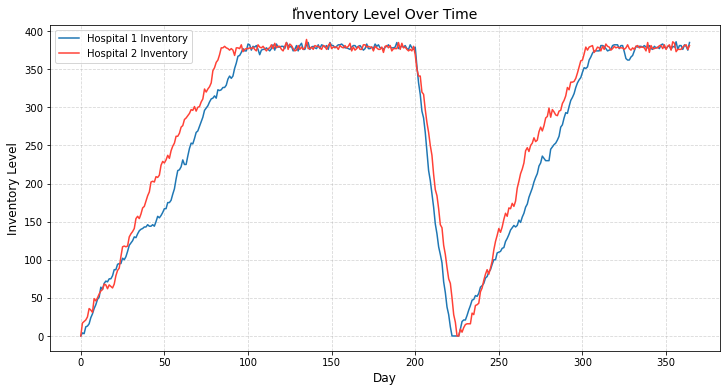

In [55]:
# Plot Transshipment h1 and h2 in the same plot
plt.figure(figsize=(12, 6))
plt.plot(h1_inventory_level, label="Hospital 1 Inventory")   
plt.plot(h2_inventory_level, label="Hospital 2 Inventory", color='#FF4136')
plt.title("ّInventory Level Over Time", fontsize=14)
plt.xlabel("Day", fontsize=12)
plt.ylabel("Inventory Level", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()